In [1]:
import numpy as np
import sys, os, git
import pint
ureg = pint.UnitRegistry()

In [3]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(git_path+'/pyplot-perso')
sys.path.append(git_path+"/pyplot-perso/colors")
from plttools import PltTools
sys.path.append(git_path+'/scripts')
from plotting_script import scan_directory, measure_isotherm, evaluate_gomc_performances

# LAMMPS data

In [6]:
lammps_dir, lammps_mu_K = scan_directory(ureg, dir_lammps = True,
                                         binary_fluid = True)
lammps_rho_g_cm3_CO2 = measure_isotherm(lammps_dir, ["CO2"], ureg)
gomc_rho_g_cm3_H2O = measure_isotherm(lammps_dir, ["H2O"], ureg)

NameError: name 'ureg' is not defined

In [4]:
performance_lammps = []
out_data = []
for dir, mu in zip(lammps_dir, lammps_mu_K):
    N_GCMC_step = 2500000/100
    if mu.magnitude > 4100:
        Nattempt=10
    else:
        Nattempt=100
    log_file = open(dir+"/log.lammps")
    for line in log_file:
        pass
    h, m, s = line.split("Total wall time: ")[1][:-1].split(":")
    total_time = np.float32(h)*60+np.float32(m) # minutes
    total_GCMC_attempts = np.int32(N_GCMC_step*Nattempt)
    performance_lammps.append([mu.magnitude, total_time, total_GCMC_attempts])
performance_lammps = np.array(performance_lammps)

NameError: name 'lammps_dir' is not defined

# GOMC data

In [5]:
gomc_dir, gomc_mu_K = scan_directory(ureg, dir_lammps = False,
                                     binary_fluid = True)
gomc_rho_g_cm3_CO2 = measure_isotherm(gomc_dir, ["CO", "OC"], ureg)
gomc_rho_g_cm3_H2O = measure_isotherm(gomc_dir, ["HO", "OH"], ureg)
performance_gomc = evaluate_gomc_performances(gomc_dir,
                                              gomc_mu_K.magnitude[:,0])

# Plot

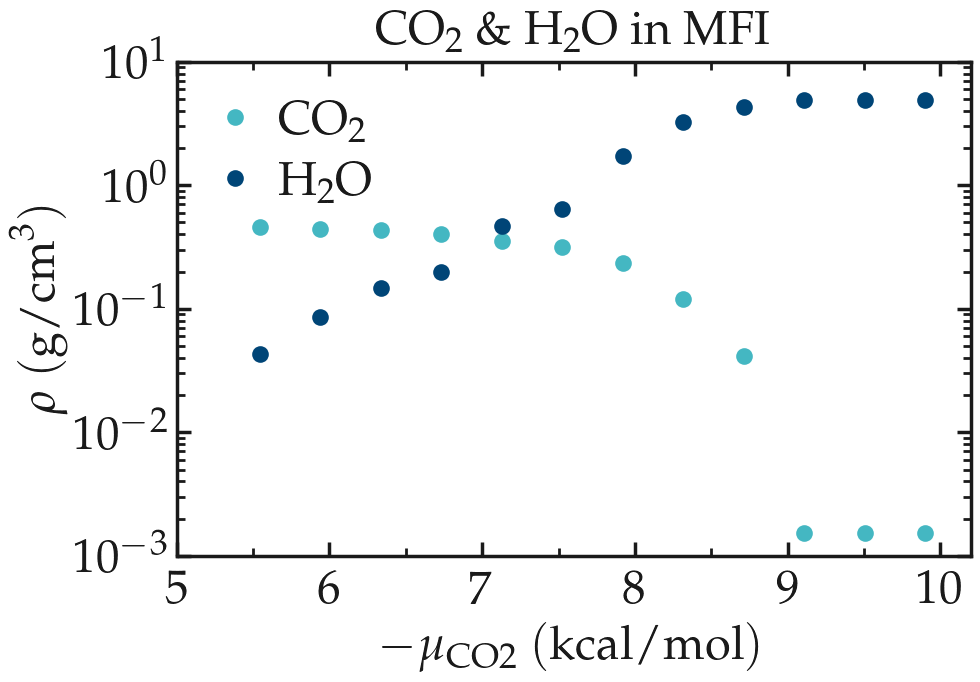

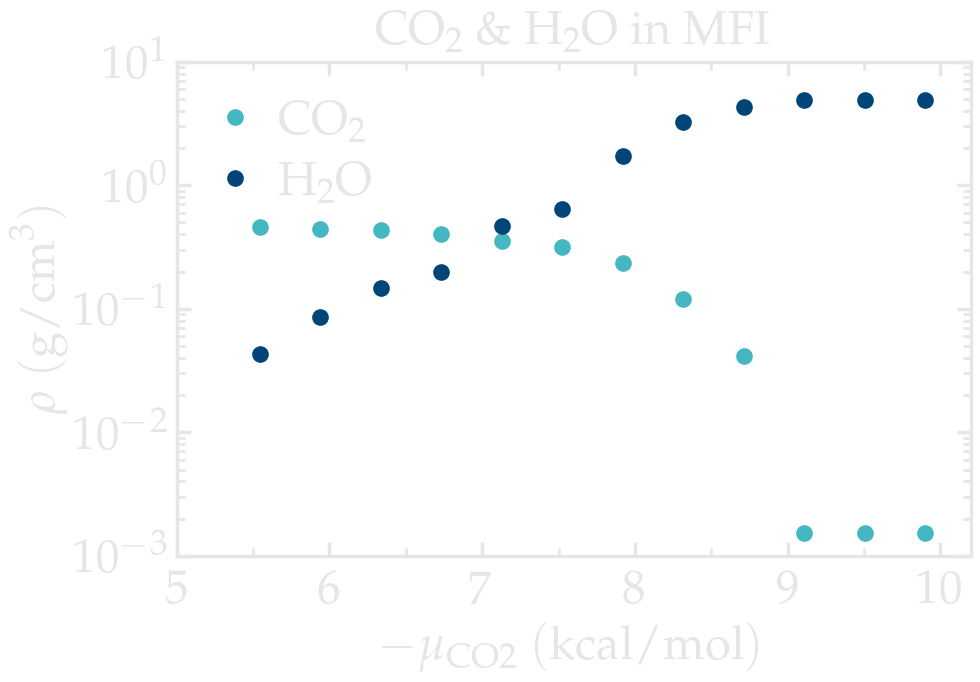

In [11]:
for dark_mode in [False, True]:

    # Initialise figure
    myplt = PltTools()
    myplt.prepare_figure(fig_size = (18,12), dark_mode = dark_mode,
                         transparency = True, n_colone = 1)
    # Panel 1
    myplt.add_panel(panel_position = [0, 0])
    myplt.add_plot(x = gomc_mu_K.magnitude[:,0]*0.00198,
                   y = gomc_rho_g_cm3_CO2.magnitude,
                   type = "semilogy",
                   marker = "o", data_color = 0,
                   markersize = 12, data_label = r"$\textrm{CO}_2$")
    myplt.add_plot(x = gomc_mu_K.magnitude[:,0]*0.00198,
                   y = gomc_rho_g_cm3_H2O.magnitude,
                   type = "semilogy",
                   marker = "o", data_color = 2,
                   markersize = 12, data_label = r"$\textrm{H}_2\textrm{O}$")
    myplt.complete_panel(xlabel = r"$-\mu_\mathrm{CO2} ~ (\textrm{kcal/mol})$",
                         ylabel = r"$\rho ~ (\textrm{g/cm}^3)$",
                         panel_title = r"$\textrm{CO$_2$ \& H$_2$O in MFI}$",
                         xpad = 10, legend=True)
    myplt.set_boundaries(x_boundaries = (5, 10.2), y_boundaries = (1e-3, 10))
    # Finish figure
    myplt.save_figure(filename = "CO2-H2O", saving_path = './')

In [ ]:
for dark_mode in [False, True]:

    # Initialise figure
    myplt = PltTools()
    myplt.prepare_figure(fig_size = (18,12), dark_mode = dark_mode,
                         transparency = True, n_colone = 1)
    # Panel 1
    myplt.add_panel(panel_position = [0, 0])
    myplt.add_plot(x = performance_gomc[:,0]*0.00198,
                   y = performance_gomc[:,2]/performance_gomc[:,1],
                   type = "semilogy",
                   marker = "o", data_color = 0,
                   markersize = 12, data_label = r"$\textrm{GOMC}$")
    myplt.add_plot(x = performance_lammps[:,0]*0.00198,
                   y = performance_lammps[:,2]/performance_lammps[:,1],
                   type = "semilogy",
                   marker = "s", data_color = 1,
                   markersize = 12, data_label = r"$\textrm{LAMMPS}$")
    myplt.complete_panel(xlabel = r"$-\mu ~ (\textrm{kcal/mol})$",
                         ylabel = r"$\textrm{GCMC attempts / min}$",
                         panel_title = r"$\textrm{Bulk CO$_2$}$",
                         xpad = 10, legend=True)
    myplt.set_boundaries(y_boundaries = (2000, 500000))
    # Finish figure
    # myplt.add_subplotlabels(type_label_panel = "a")
    myplt.save_figure(filename = "CO2-performance", saving_path = './')